<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/SRAG_2021_a_2023S1_openDataSUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRAG 2021 a 2023 - Banco de Dados de Síndrome Respiratória Aguda Grave

Dados atualizados até 22 de Fevereiro de 2023

https://opendatasus.saude.gov.br/dataset/srag-2021-a-2023

In [ ]:
# Instalar pt_BR
!/usr/share/locales/install-language-pack pt_BR
!dpkg-reconfigure locales

import os

# Reiniciar o Python
os.kill(os.getpid(), 9)

Generating locales (this might take a while)...
  pt_BR.ISO-8859-1... done
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.
Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


# Importações

In [190]:
import numpy as np
import pandas as pd

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

import datetime, locale

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Configurações

In [191]:
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

locale.setlocale(locale.LC_ALL, 'pt_BR')

SEMENTE  = 2001088 + 2001247 + 2003061 + 2008193 + 2008620 + 2008880
COLORMAP = 'summer_r'
CORES    = ['#008066', '#609F6C', '#A7C774', '#FFFF66']

SEXO_ROTULOS = ['Masculino', 'Feminino']

# Dados

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.001
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.002
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.003
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.004

!7z e /content/openDataSUS.7z.001

--2023-02-26 01:26:57--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25165824 (24M) [application/octet-stream]
Saving to: ‘openDataSUS.7z.001’

openDataSUS.7z.001  100%[===================>]  24.00M   153MB/s    in 0.2s    

2023-02-26 01:26:57 (153 MB/s) - ‘openDataSUS.7z.001’ saved [25165824/25165824]

--2023-02-26 01:26:57--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/openDataSUS.7z.002
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2

In [192]:
CAMPOS = {'DT_NOTIFIC': 'string', 'SEM_NOT': 'Int32', 'DT_SIN_PRI': 'string', 'SEM_PRI': 'Int32', 'SG_UF_NOT': 'string', 'ID_REGIONA': 'string', 'CO_REGIONA': 'Int32',
          'ID_MUNICIP': 'string', 'CO_MUN_NOT': 'Int32', 'ID_UNIDADE': 'string', 'CO_UNI_NOT': 'Int32', 'CS_SEXO': 'string', 'DT_NASC': 'string', 'NU_IDADE_N': 'Int32',
          'TP_IDADE': 'Int32', 'COD_IDADE': 'string', 'CS_GESTANT': 'Int32', 'CS_RACA': 'Int32', 'CS_ESCOL_N': 'Int32', 'ID_PAIS': 'string', 'CO_PAIS': 'Int32',
          'SG_UF': 'string', 'ID_RG_RESI': 'string', 'CO_RG_RESI': 'Int32', 'ID_MN_RESI': 'string', 'CO_MUN_RES': 'Int32', 'CS_ZONA': 'Int32', 'SURTO_SG': 'string',
          'NOSOCOMIAL': 'Int32', 'AVE_SUINO': 'Int32', 'FEBRE': 'Int32', 'TOSSE': 'Int32', 'GARGANTA': 'Int32', 'DISPNEIA': 'Int32', 'DESC_RESP': 'Int32', 'SATURACAO': 'Int32',
          'DIARREIA': 'Int32', 'VOMITO': 'Int32', 'OUTRO_SIN': 'Int32', 'OUTRO_DES': 'string', 'PUERPERA': 'Int32', 'FATOR_RISC': 'Int32', 'CARDIOPATI': 'Int32',
          'HEMATOLOGI': 'Int32', 'SIND_DOWN': 'Int32', 'HEPATICA': 'Int32', 'ASMA': 'Int32', 'DIABETES': 'Int32', 'NEUROLOGIC': 'Int32', 'PNEUMOPATI': 'Int32',
          'IMUNODEPRE': 'Int32', 'RENAL': 'Int32', 'OBESIDADE': 'Int32', 'OBES_IMC': 'string', 'OUT_MORBI': 'Int32', 'MORB_DESC': 'string', 'VACINA': 'Int32',
          'DT_UT_DOSE': 'string', 'MAE_VAC': 'Int32', 'DT_VAC_MAE': 'string', 'M_AMAMENTA': 'Int32', 'DT_DOSEUNI': 'string', 'DT_1_DOSE': 'string', 'DT_2_DOSE': 'string',
          'ANTIVIRAL': 'Int32', 'TP_ANTIVIR': 'Int32', 'OUT_ANTIV': 'string', 'DT_ANTIVIR': 'string', 'HOSPITAL': 'Int32', 'DT_INTERNA': 'string', 'SG_UF_INTE': 'string',
          'ID_RG_INTE': 'string', 'CO_RG_INTE': 'Int32', 'ID_MN_INTE': 'string', 'CO_MU_INTE': 'Int32', 'UTI': 'Int32', 'DT_ENTUTI': 'string', 'DT_SAIDUTI': 'string',
          'SUPORT_VEN': 'Int32', 'RAIOX_RES': 'Int32', 'RAIOX_OUT': 'string', 'DT_RAIOX': 'string', 'AMOSTRA': 'Int32', 'DT_COLETA': 'string', 'TP_AMOSTRA': 'Int32',
          'OUT_AMOST': 'string', 'PCR_RESUL': 'Int32', 'DT_PCR': 'string', 'POS_PCRFLU': 'Int32', 'TP_FLU_PCR': 'Int32', 'PCR_FLUASU': 'Int32', 'FLUASU_OUT': 'string',
          'PCR_FLUBLI': 'Int32', 'FLUBLI_OUT': 'string', 'POS_PCROUT': 'Int32', 'PCR_VSR': 'Int32', 'PCR_PARA1': 'Int32', 'PCR_PARA2': 'Int32', 'PCR_PARA3': 'Int32',
          'PCR_PARA4': 'Int32', 'PCR_ADENO': 'Int32', 'PCR_METAP': 'Int32', 'PCR_BOCA': 'Int32', 'PCR_RINO': 'Int32', 'PCR_OUTRO': 'Int32', 'DS_PCR_OUT': 'string',
          'CLASSI_FIN': 'Int32', 'CLASSI_OUT': 'string', 'CRITERIO': 'Int32', 'EVOLUCAO': 'Int32', 'DT_EVOLUCA': 'string', 'DT_ENCERRA': 'string', 'DT_DIGITA': 'string',
          'HISTO_VGM': 'string', 'PAIS_VGM': 'string', 'CO_PS_VGM': 'string', 'LO_PS_VGM': 'string', 'DT_VGM': 'string', 'DT_RT_VGM': 'string', 'PCR_SARS2': 'Int32',
          'PAC_COCBO': 'string', 'PAC_DSCBO': 'string', 'OUT_ANIM': 'string', 'DOR_ABD': 'Int32', 'FADIGA': 'Int32', 'PERD_OLFT': 'Int32', 'PERD_PALA': 'Int32',
          'TOMO_RES': 'Int32', 'TOMO_OUT': 'string', 'DT_TOMO': 'string', 'TP_TES_AN': 'Int32', 'DT_RES_AN': 'string', 'RES_AN': 'Int32', 'POS_AN_FLU': 'Int32',
          'TP_FLU_AN': 'Int32', 'POS_AN_OUT': 'Int32', 'AN_SARS2': 'Int32', 'AN_VSR': 'Int32', 'AN_PARA1': 'Int32', 'AN_PARA2': 'Int32', 'AN_PARA3': 'Int32',
          'AN_ADENO': 'Int32', 'AN_OUTRO': 'Int32', 'DS_AN_OUT': 'string', 'TP_AM_SOR': 'Int32', 'SOR_OUT': 'string', 'DT_CO_SOR': 'string', 'TP_SOR': 'Int32',
          'OUT_SOR': 'string', 'DT_RES': 'string', 'RES_IGG': 'Int32', 'RES_IGM': 'Int32', 'RES_IGA': 'Int32', 'ESTRANG': 'Int32', 'VACINA_COV': 'Int32',
          'DOSE_1_COV': 'string', 'DOSE_2_COV': 'string', 'DOSE_REF': 'string', 'FAB_COV_1': 'string', 'FAB_COV_2': 'string', 'FAB_COVREF': 'string', 'LAB_PR_COV': 'string',
          'LOTE_1_COV': 'string', 'LOTE_2_COV': 'string', 'LOTE_REF': 'string', 'FNT_IN_COV': 'Int32', 'DOSE_2REF': 'string', 'FAB_COVRF2': 'string', 'LOTE_REF2': 'string',
          'TRAT_COV': 'Int32', 'TIPO_TRAT': 'Int32', 'OUT_TRAT': 'string', 'DT_TRT_COV': 'string'}

# AUSENTES = df_23.columns[~df_23.columns.isin(df_21.columns)]
AUSENTES = ['DOSE_2REF', 'FAB_COVRF2', 'LOTE_REF2', 'TRAT_COV', 'TIPO_TRAT', 'OUT_TRAT', 'DT_TRT_COV']

DATAS = ['DT_NOTIFIC', 'DT_SIN_PRI', 'DT_NASC', 'DT_UT_DOSE', 'DT_VAC_MAE', 'DT_DOSEUNI', 'DT_1_DOSE', 'DT_2_DOSE', 'DT_ANTIVIR', 'DT_INTERNA',
         'DT_ENTUTI', 'DT_SAIDUTI', 'DT_RAIOX', 'DT_COLETA', 'DT_PCR', 'DT_EVOLUCA', 'DT_ENCERRA', 'DT_DIGITA', 'DT_VGM', 'DT_RT_VGM', 'DT_TOMO',
         'DT_RES_AN', 'DT_CO_SOR', 'DT_RES', 'DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF', 'DOSE_2REF', 'DT_TRT_COV']

In [193]:
%%time

df = pd.read_csv('INFLUD21-20-02-2023.csv', sep=';', dtype=dict(list(CAMPOS.items())[:-7]))

CPU times: user 1min 52s, sys: 5.58 s, total: 1min 57s
Wall time: 2min 2s


In [194]:
df[AUSENTES] = [None] * len(AUSENTES)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [195]:
%%time

df = pd.concat([df, pd.read_csv('INFLUD22-13-02-2023.csv', sep=';', dtype=CAMPOS)])
df = pd.concat([df, pd.read_csv('INFLUD23-13-02-2023.csv', sep=';', dtype=CAMPOS)])

CPU times: user 1min 33s, sys: 1.78 s, total: 1min 34s
Wall time: 1min 54s


In [196]:
%%time

for campo in DATAS:
    df[campo] = pd.to_datetime(df[campo], format='%d/%m/%Y', errors='coerce')

CPU times: user 35.5 s, sys: 135 ms, total: 35.6 s
Wall time: 36.2 s


In [197]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Columns: 173 entries, DT_NOTIFIC to DT_TRT_COV
dtypes: Int32(99), datetime64[ns](29), string(45)
memory usage: 2.4 GB


## População estimada em 2021

https://www.ibge.gov.br/cidades-e-estados

In [198]:
df_populacao = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/populacao_estimada_2021.csv')

In [199]:
df_populacao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   UF         27 non-null     object
 1   Nome       27 non-null     object
 2   Populacao  27 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 776.0+ bytes


## Pré-processamento

### Contagem

In [200]:
# Campos de notificação e primeiros sintomas.
CAMPOS = ['DT_NOTIFIC', 'SEM_NOT', 'SG_UF_NOT', 'DT_SIN_PRI', 'SEM_PRI']

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   DT_NOTIFIC  2310360 non-null  datetime64[ns]
 1   SEM_NOT     2310360 non-null  Int32         
 2   SG_UF_NOT   2310360 non-null  string        
 3   DT_SIN_PRI  2310360 non-null  datetime64[ns]
 4   SEM_PRI     2310360 non-null  Int32         
dtypes: Int32(2), datetime64[ns](2), string(1)
memory usage: 92.5 MB


None

In [201]:
# # Campos descritos no dicionário de dados, mas inexistentes nas fontes.
# INEXISTENTES = ['TEM_CPF', 'NU_CPF', 'NU_CNS', 'NM_PACIENT', 'TP_POV_CT', 'NM_MAE_PAC', 'NM_BAIRRO', 'NM_LOGRADO', 'NU_NUMERO',
#                 'NM_COMPLEM', 'NU_DDD_TEL', 'NU_TELEFON', 'ID_UN_INTE', 'CO_UN_INTE', 'REQUI_GAL', 'LAB_AN', 'CO_LAB_AN',
#                 'LAB_PCR', 'CO_LAB_PCR', 'NU_DO', 'OBSERVA', 'NOME_PROF', 'REG_PROF', 'CS_ETINIA', 'POV_CT', 'NU_CEP']

In [202]:
# Campos sem entrada no dicionário.
CAMPOS = ['COD_IDADE', 'LAB_PR_COV', 'SURTO_SG', 'HISTO_VGM', 'CO_PS_VGM', 'LO_PS_VGM', 'PAIS_VGM']

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   COD_IDADE   2310360 non-null  string
 1   LAB_PR_COV  685394 non-null   string
 2   SURTO_SG    137119 non-null   string
 3   HISTO_VGM   2310360 non-null  string
 4   CO_PS_VGM   62 non-null       string
 5   LO_PS_VGM   42 non-null       string
 6   PAIS_VGM    62 non-null       string
dtypes: string(7)
memory usage: 141.0 MB


None

In [203]:
# Campos de conteúdo diverso.
CAMPOS = ['NU_IDADE_N', 'TP_IDADE', 'ID_UNIDADE', 'CO_UNI_NOT', 'OUT_ANIM', 'OUTRO_DES', 'OBES_IMC', 'MORB_DESC',
          'LOTE_1_COV', 'LOTE_2_COV', 'LOTE_REF', 'LOTE_REF2', 'OUT_ANTIV', 'OUT_TRAT', 'RAIOX_OUT', 'TOMO_OUT', 'OUT_AMOST',
          'DS_AN_OUT', 'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'SOR_OUT', 'OUT_SOR', 'CLASSI_OUT', 'ID_MUNICIP', 'CO_MUN_NOT',
          'ID_REGIONA', 'CO_REGIONA', 'PAC_COCBO', 'PAC_DSCBO', 'ID_RG_RESI', 'CO_RG_RESI', 'ID_MN_RESI', 'CO_MUN_RES',
          'ID_RG_INTE', 'CO_RG_INTE', 'ID_MN_INTE', 'CO_MU_INTE', 'FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF', 'FAB_COVRF2']

# 'FAB_COV_1', 'FAB_COV_2', 'FAB_COVREF' = 'FAB_COV1', 'FAB_COV2', 'FAB_COVRF' (no dicionário)

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 42 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   NU_IDADE_N  2310360 non-null  Int32 
 1   TP_IDADE    2310360 non-null  Int32 
 2   ID_UNIDADE  2310360 non-null  string
 3   CO_UNI_NOT  2310360 non-null  Int32 
 4   OUT_ANIM    2019 non-null     string
 5   OUTRO_DES   694988 non-null   string
 6   OBES_IMC    23894 non-null    string
 7   MORB_DESC   552988 non-null   string
 8   LOTE_1_COV  590153 non-null   string
 9   LOTE_2_COV  493157 non-null   string
 10  LOTE_REF    192595 non-null   string
 11  LOTE_REF2   33170 non-null    string
 12  OUT_ANTIV   6815 non-null     string
 13  OUT_TRAT    709 non-null      string
 14  RAIOX_OUT   78938 non-null    string
 15  TOMO_OUT    62783 non-null    string
 16  OUT_AMOST   186145 non-null   string
 17  DS_AN_OUT   1299 non-null     string
 18  FLUASU_OUT  267 non-null      string
 19  FL

None

In [204]:
# Campos "marcado pelo usuário" ou vazio.
CAMPOS = ['AN_ADENO', 'AN_OUTRO', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_SARS2', 'AN_VSR', 'PCR_ADENO', 'PCR_BOCA', 'PCR_METAP',
          'PCR_OUTRO', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_RINO', 'PCR_SARS2', 'PCR_VSR']

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   AN_ADENO   166 non-null     Int32
 1   AN_OUTRO   1429 non-null    Int32
 2   AN_PARA1   72 non-null      Int32
 3   AN_PARA2   23 non-null      Int32
 4   AN_PARA3   157 non-null     Int32
 5   AN_SARS2   330875 non-null  Int32
 6   AN_VSR     6953 non-null    Int32
 7   PCR_ADENO  4630 non-null    Int32
 8   PCR_BOCA   2038 non-null    Int32
 9   PCR_METAP  2743 non-null    Int32
 10  PCR_OUTRO  2382 non-null    Int32
 11  PCR_PARA1  549 non-null     Int32
 12  PCR_PARA2  261 non-null     Int32
 13  PCR_PARA3  1877 non-null    Int32
 14  PCR_PARA4  597 non-null     Int32
 15  PCR_RINO   13955 non-null   Int32
 16  PCR_SARS2  798935 non-null  Int32
 17  PCR_VSR    28086 non-null   Int32
dtypes: Int32(18)
memory usage: 215.9 MB


None

In [205]:
# Campos relativos a internação.
CAMPOS = ['HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'ID_RG_INTE', 'CO_RG_INTE', 'ID_MN_INTE', 'CO_MU_INTE']

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   HOSPITAL    2245036 non-null  Int32         
 1   DT_INTERNA  2157993 non-null  datetime64[ns]
 2   SG_UF_INTE  2239369 non-null  string        
 3   ID_RG_INTE  1800956 non-null  string        
 4   CO_RG_INTE  1800956 non-null  Int32         
 5   ID_MN_INTE  2163407 non-null  string        
 6   CO_MU_INTE  2163407 non-null  Int32         
dtypes: Int32(3), datetime64[ns](1), string(3)
memory usage: 121.2 MB


None

In [206]:
# Campos relativos a origem e país.
CAMPOS = ['ESTRANG', 'ID_PAIS', 'CO_PAIS']

display(df[CAMPOS].info(show_counts=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype 
---  ------   --------------    ----- 
 0   ESTRANG  1798643 non-null  Int32 
 1   ID_PAIS  2310360 non-null  string
 2   CO_PAIS  2310360 non-null  Int32 
dtypes: Int32(2), string(1)
memory usage: 57.3 MB


None

In [207]:
# "Idade gestacional da paciente."
df['CS_GESTANT'].value_counts(dropna=False).sort_index()

0          378
1         2511
2         5809
3        14226
4         1216
5       694357
6      1498864
9        92999
NaN          0
Name: CS_GESTANT, dtype: Int64

In [208]:
# "Resultado da Sorologia para SARS-CoV-2." ???
CAMPOS = ['RES_IGG', 'RES_IGM', 'RES_IGA']

display(df[CAMPOS].info(show_counts=True))
print()

for campo in CAMPOS:
    display(df[campo].value_counts(dropna=False).sort_index())
    print()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   RES_IGG  256592 non-null  Int32
 1   RES_IGM  259464 non-null  Int32
 2   RES_IGA  202793 non-null  Int32
dtypes: Int32(3)
memory usage: 50.7 MB


None

1        66689
2        42115
3          230
4       142326
5          401
9         4831
NaN    2053768
Name: RES_IGG, dtype: Int64

1        72106
2        41409
3          281
4       140601
5          429
9         4638
NaN    2050896
Name: RES_IGM, dtype: Int64

1         6174
2         4952
3          409
4       182458
5          586
9         8214
NaN    2107567
Name: RES_IGA, dtype: Int64

In [209]:
# Campos de datas.
df[DATAS].info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2310360 entries, 0 to 22642
Data columns (total 29 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   DT_NOTIFIC  2310360 non-null  datetime64[ns]
 1   DT_SIN_PRI  2310360 non-null  datetime64[ns]
 2   DT_NASC     2308970 non-null  datetime64[ns]
 3   DT_UT_DOSE  92107 non-null    datetime64[ns]
 4   DT_VAC_MAE  1186 non-null     datetime64[ns]
 5   DT_DOSEUNI  236 non-null      datetime64[ns]
 6   DT_1_DOSE   239 non-null      datetime64[ns]
 7   DT_2_DOSE   189 non-null      datetime64[ns]
 8   DT_ANTIVIR  51194 non-null    datetime64[ns]
 9   DT_INTERNA  2157993 non-null  datetime64[ns]
 10  DT_ENTUTI   637296 non-null   datetime64[ns]
 11  DT_SAIDUTI  383907 non-null   datetime64[ns]
 12  DT_RAIOX    468513 non-null   datetime64[ns]
 13  DT_COLETA   2097590 non-null  datetime64[ns]
 14  DT_PCR      1481952 non-null  datetime64[ns]
 15  DT_EVOLUCA  1940601 non-null  date

In [210]:
# with pd.option_context('display.max_columns', None): 
#     display(df[DATAS].describe(datetime_is_numeric=True))

In [211]:
# Quantidade de registros com sexo diferente de Masculino ou Feminino.
(~df['CS_SEXO'].isin(['M', 'F'])).sum()

376

In [212]:
# Quantidade de registros sem data de nascimento.
df['DT_NASC'].isna().sum()

1390

In [213]:
# # Quantidade de registros com ano de nascimento inferior a 1923, por ano.
# with pd.option_context('display.max_rows', None): 
#     display(df['DT_NASC'][df['DT_NASC'].dt.year < 1923].dt.year.value_counts().sort_index())

In [214]:
# Quantidade total de registros com ano de nascimento inferior a 1923.
(df['DT_NASC'].dt.year < 1923).sum()

6137

In [215]:
# Quantidade de registros sem unidade federativa.
df['SG_UF'].isna().sum()

398

### Correção

In [216]:
# Campos "marcado pelo usuário" com valores NaN para 0.
NAN0 = ['AN_ADENO', 'AN_OUTRO', 'AN_PARA1', 'AN_PARA2', 'AN_PARA3', 'AN_SARS2', 'AN_VSR', 'PCR_ADENO', 'PCR_BOCA',
        'PCR_METAP', 'PCR_OUTRO', 'PCR_PARA1', 'PCR_PARA2', 'PCR_PARA3', 'PCR_PARA4', 'PCR_RINO', 'PCR_SARS2', 'PCR_VSR']

for campo in NAN0:
    df[campo].fillna(0, inplace=True)

# Campo CLASSI_FIN com valores NaN para 4-SRAG não especificado
df['CLASSI_FIN'].fillna(4, inplace=True)

# Campo CS_SEXO para numérico, como dicionário de dados.
df['CS_SEXO'].replace({'M': 1, 'F': 2, 'I': 9}, inplace=True)
df['CS_SEXO'] = df['CS_SEXO'].astype('Int32')

# Campos com valores NaN para 9-Ignorado.
NAN9 = ['AMOSTRA', 'ANTIVIRAL', 'ASMA', 'AVE_SUINO', 'CARDIOPATI', 'CRITERIO', 'CS_ESCOL_N', 'CS_RACA', 'CS_ZONA', 'DESC_RESP', 'DIABETES',
        'DIARREIA', 'DISPNEIA', 'DOR_ABD', 'EVOLUCAO', 'FADIGA', 'FATOR_RISC', 'FEBRE', 'FNT_IN_COV', 'GARGANTA', 'HEMATOLOGI', 'HEPATICA',
        'HOSPITAL', 'IMUNODEPRE', 'MAE_VAC', 'M_AMAMENTA', 'NEUROLOGIC', 'NOSOCOMIAL', 'OBESIDADE', 'OUTRO_SIN', 'OUT_MORBI', 'PCR_FLUASU',
        'PCR_FLUBLI', 'PCR_RESUL', 'PERD_OLFT', 'PERD_PALA', 'PNEUMOPATI', 'POS_AN_FLU', 'POS_AN_OUT', 'POS_PCRFLU', 'POS_PCROUT', 'PUERPERA',
        'RAIOX_RES', 'RENAL', 'RES_AN', 'SATURACAO', 'SIND_DOWN', 'SUPORT_VEN', 'TIPO_TRAT', 'TOMO_RES', 'TOSSE', 'TP_AMOSTRA', 'TP_AM_SOR',
        'TP_ANTIVIR', 'TP_FLU_AN', 'TP_FLU_PCR', 'TP_SOR', 'TP_TES_AN', 'TRAT_COV', 'UTI', 'VACINA', 'VACINA_COV', 'VOMITO']

for campo in NAN9:
    df[campo].fillna(9, inplace=True)

# Campo OBES_IMC para decimal.
df['OBES_IMC'][df['OBES_IMC'].str.contains(',', regex=False)] = df['OBES_IMC'][df['OBES_IMC'].str.contains(',', regex=False)].str.replace(',', '.')
df['OBES_IMC'] = df['OBES_IMC'].astype('Float32')

# Campos PAC_COCBO com valores 'XXX' para None.
df['PAC_COCBO'].replace({'XXX': None}, inplace=True)

# Campos PAC_DSCBO com valores 'NAO INFORMADO' para None.
df['PAC_DSCBO'].replace({'NAO INFORMADO': None}, inplace=True)

### Desmembramento

In [217]:
# DataFrame de ocupações, com códigos e descrições.

ocupacoes = ['PAC_COCBO', 'PAC_DSCBO']

df_ocupacoes = df[ocupacoes][~df[ocupacoes].duplicated()].dropna().sort_values(by='PAC_COCBO').reset_index(drop=True)

In [218]:
# DataFrame de unidades, com códigos e descrições.

unidades = ['CO_UNI_NOT', 'ID_UNIDADE']

df_unidades = df[unidades][~df[unidades].duplicated()].dropna().sort_values(by='CO_UNI_NOT').reset_index(drop=True)

In [219]:
# DataFrame de municípios, com códigos e descrições.

df_municipios = pd.concat([df[['CO_MUN_NOT', 'ID_MUNICIP']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1),
                           df[['CO_MUN_RES', 'ID_MN_RESI']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1),
                           df[['CO_MU_INTE', 'ID_MN_INTE']].set_axis(['CO_MUNICIP', 'ID_MUNICIP'], axis=1)])

df_municipios = df_municipios[~df_municipios.duplicated()].dropna().sort_values(by='CO_MUNICIP').reset_index(drop=True)

In [220]:
# DataFrame de regionais, com códigos e descrições.

df_regionais = pd.concat([df[['CO_REGIONA', 'ID_REGIONA']],
                          df[['CO_RG_RESI', 'ID_RG_RESI']].set_axis(['CO_REGIONA', 'ID_REGIONA'], axis=1),
                          df[['CO_RG_INTE', 'ID_RG_INTE']].set_axis(['CO_REGIONA', 'ID_REGIONA'], axis=1)])

df_regionais = df_regionais[~df_regionais.duplicated()].dropna().sort_values(by='CO_REGIONA').reset_index(drop=True)

### Limpeza

In [221]:
# Remover registros com sexo diferente de 1-Masculino ou 2-Feminino.
df.drop(df[~df['CS_SEXO'].isin([1, 2])].index, inplace=True)

# Remover registros sem data de nascimento ou unidade federativa.
df.dropna(subset=['DT_NASC', 'SG_UF'], inplace=True)

# Remover registros com ano de nascimento inferior a 1923.
df.drop(df[df['DT_NASC'].dt.year < 1923].index, inplace=True)

# Remover registros de pacientes estrangeiros.
df.drop(df[df['ESTRANG'] == 1].index, inplace=True)

# Remover campos vazios.
df.dropna(how='all', axis=1, inplace=True)

# Remover campos relativos ao país de origem. (Ao remover registros de pacientes estrangeiros ou sem unidade federativa, ficamos com apenas um valor nestes campos.)
df.drop(['ESTRANG', 'ID_PAIS', 'CO_PAIS'], axis=1, inplace=True)

# Remover campos de descrição dos dados desmembrados.
df.drop(['PAC_DSCBO', 'ID_UNIDADE', 'ID_MUNICIP', 'ID_MN_RESI', 'ID_MN_INTE', 'ID_REGIONA', 'ID_RG_RESI', 'ID_RG_INTE'], axis=1, inplace=True)

# Remover campos sem entrada no dicionário.
df.drop(['COD_IDADE', 'LAB_PR_COV', 'SURTO_SG', 'HISTO_VGM', 'CO_PS_VGM', 'LO_PS_VGM', 'PAIS_VGM'], axis=1, inplace=True)

# Remover campos relativos à idade. (Temos a data de nascimento.)
df.drop(['NU_IDADE_N', 'TP_IDADE'], axis=1, inplace=True)

# Remover campos tipo 'Outro'. (Sem utilidade para macro-análises.)
df.drop(['OUT_ANIM', 'OUTRO_DES', 'MORB_DESC', 'OUT_ANTIV', 'OUT_TRAT', 'RAIOX_OUT', 'TOMO_OUT', 'OUT_AMOST',
         'DS_AN_OUT', 'FLUASU_OUT', 'FLUBLI_OUT', 'DS_PCR_OUT', 'SOR_OUT', 'OUT_SOR', 'CLASSI_OUT'], axis=1, inplace=True)

# Remover campos sobre resultado da sorologia para SARS-CoV-2. (O dicionário não contém a descrição dos valores.)
df.drop(['RES_IGG', 'RES_IGM', 'RES_IGA'], axis=1, inplace=True)

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2277840 entries, 0 to 22642
Columns: 134 entries, DT_NOTIFIC to TIPO_TRAT
dtypes: Float32(1), Int32(93), datetime64[ns](28), object(1), string(11)
memory usage: 1.7+ GB


In [223]:
# with pd.option_context('display.max_rows', None):
#     df.info(verbose=True, show_counts=True)

In [224]:
# with pd.option_context('display.max_rows', None):
#     display(df[df.columns[df.isna().any()]].isna().sum())

# Análise

## Notificações por 1000 habitantes por unidade federativa

In [225]:
df_populacao['Notificacoes'] = df['SG_UF_NOT'].value_counts().sort_index().to_list()
df_populacao['NotificacoesPor1000'] = df_populacao['Notificacoes'] / (df_populacao['Populacao'] / 1000)

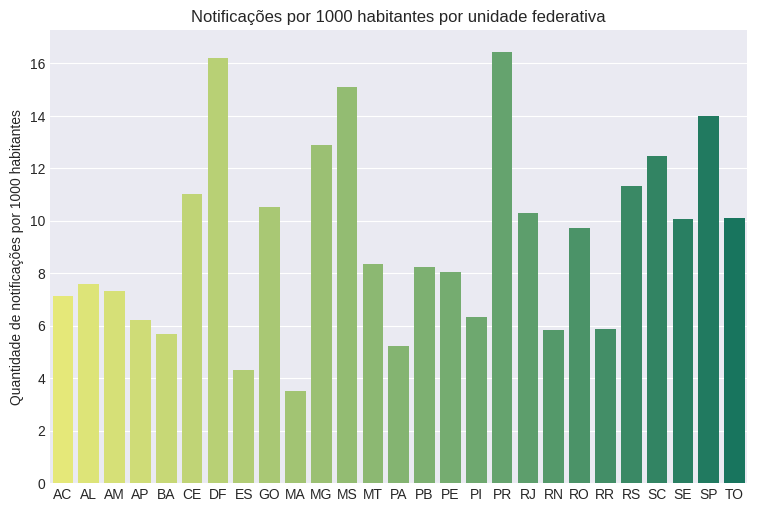

In [226]:
sns.barplot(data=df_populacao, x='UF', y='NotificacoesPor1000', palette=COLORMAP)

plt.title('Notificações por 1000 habitantes por unidade federativa')
plt.xlabel('')
plt.ylabel('Quantidade de notificações por 1000 habitantes');

## Notificações por unidade federativa por sexo

In [227]:
df_populacao['NotificacoesMasculino'] = df['SG_UF_NOT'][df['CS_SEXO'] == 1].value_counts().sort_index().to_list()
df_populacao['NotificacoesFeminino']  = df['SG_UF_NOT'][df['CS_SEXO'] == 2].value_counts().sort_index().to_list()

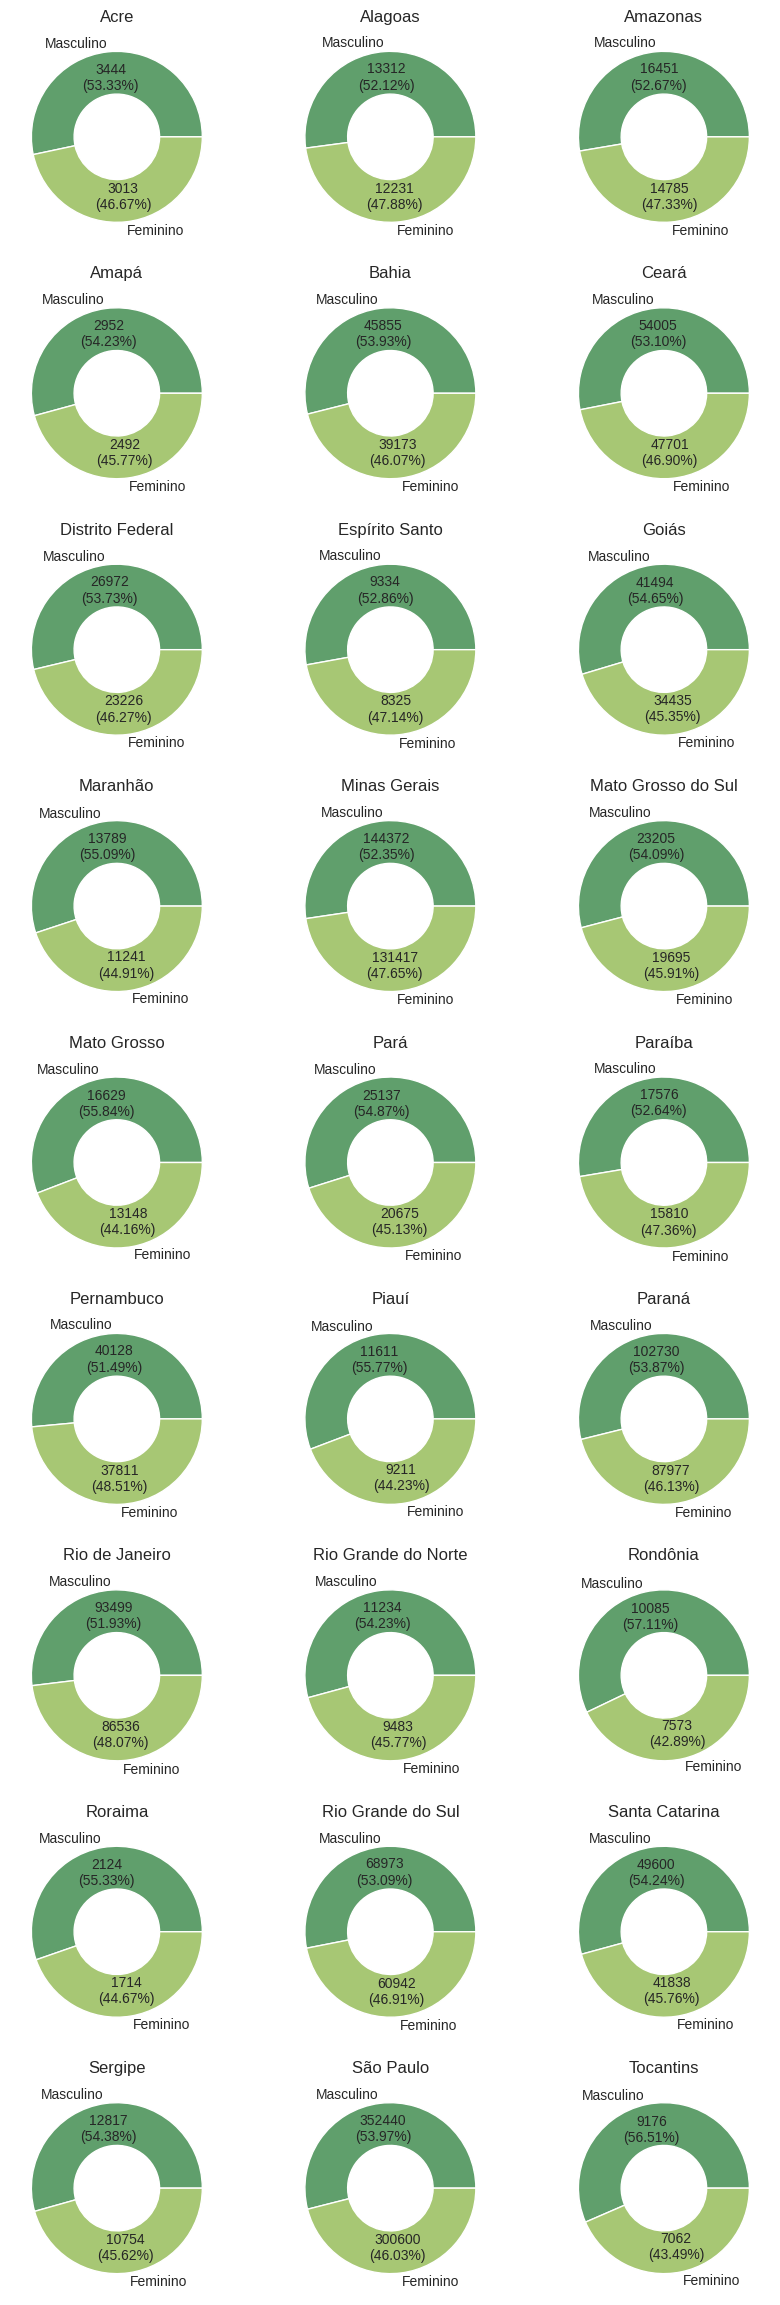

In [248]:
colunas = 3
linhas  = int(np.ceil(len(df_populacao) / colunas))

fig, ax = plt.subplots(linhas, colunas, figsize=[10, 30])

def func(pct, dados):
    return f"{int(pct / 100 * np.sum(dados))}\n({pct:0.2f}%)"

for i, uf in df_populacao.iterrows():

    dados = uf[['NotificacoesMasculino', 'NotificacoesFeminino']]

    ax[i // colunas, i % colunas].pie(dados,
                                      labels=SEXO_ROTULOS,
                                      autopct=lambda pct: func(pct, dados),
                                      pctdistance=0.7,
                                      wedgeprops={'width': 0.5,
                                                  'edgecolor': 'w'},
                                      colors=CORES[1:])

    ax[i // colunas, i % colunas].set_title(uf['Nome'])

## Diferença média de dias entre primeiros sintomas e notificação

In [229]:
df_demora = df[['DT_SIN_PRI', 'DT_NOTIFIC']].sort_values(by=['DT_SIN_PRI', 'DT_NOTIFIC']).copy().reset_index(drop=True)
df_demora['dias'] = ((df_demora['DT_NOTIFIC'] - df_demora['DT_SIN_PRI']) / np.timedelta64(1, 'D')).astype(int)
df_demora.drop(['DT_NOTIFIC'], axis=1, inplace=True)
df_demora = df_demora.groupby(by=['DT_SIN_PRI']).mean().reset_index()

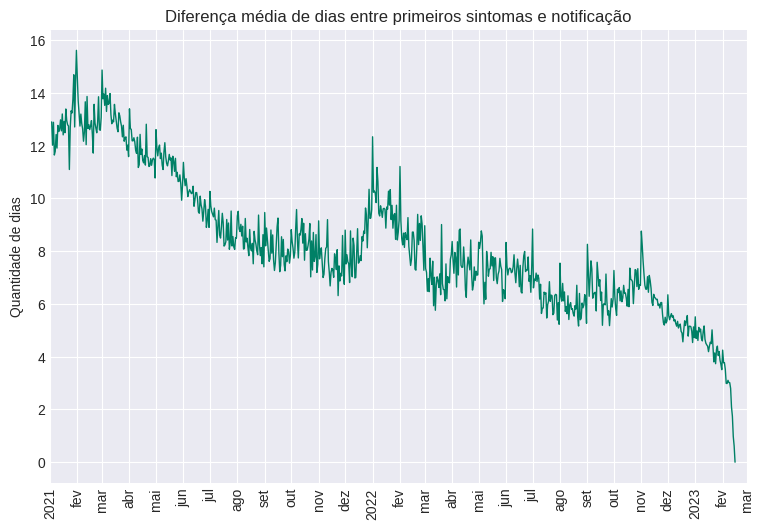

In [230]:
ax = sns.lineplot(data=df_demora, x='DT_SIN_PRI', y='dias', linewidth=1, color=CORES[0])

plt.title('Diferença média de dias entre primeiros sintomas e notificação')
plt.xlabel('')
plt.ylabel('Quantidade de dias')

plt.xlim([datetime.date(2021, 1, 1), datetime.date(2023, 3, 1)])

ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

for tick in ax.get_xticklabels(which='both'):
    tick.set_rotation(90)

plt.grid(visible=True, which='both', axis='both');

## Correlações entre sintomas

In [231]:
campos  = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN']
filtros = [df[c].isin([1, 2]) for c in campos]  # Lista de filtros.
filtro  = np.vstack(filtros).all(axis=0)        # Combina os resultados dos filtros em um único array.

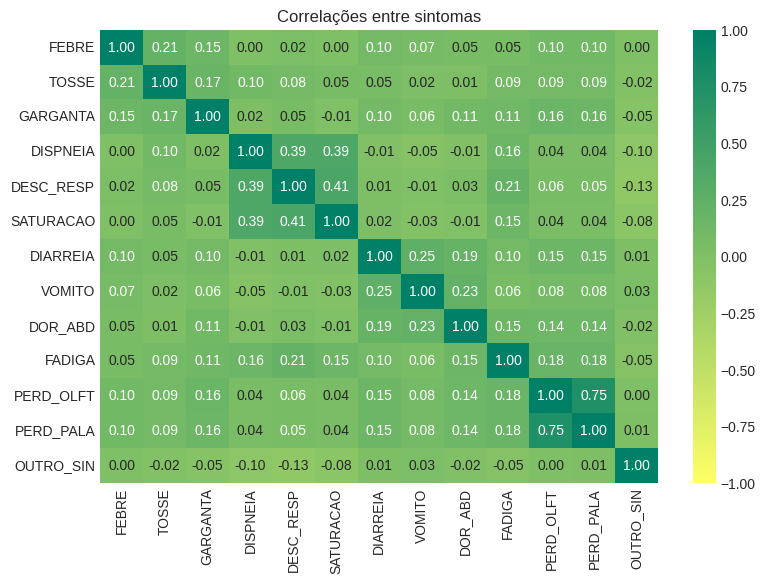

In [232]:
sns.heatmap(data=df[campos][filtro].corr(), annot=True, fmt="0.2f", vmin=-1, vmax=1, cmap=COLORMAP)

plt.title('Correlações entre sintomas');

## Anotações

In [233]:
# evoluções por semana de data
# evoluções por semana de notificação
# evoluções por uf
# evoluções por ave ou suino

# tempo de internação
# tempo de uti

# evolução por fabricante de vacina

# sexo por uf

In [234]:
# Evolução do caso.
# 1 - Cura
# 2 - Óbito
# 3 - Óbito por outras causas
# 9 - Ignorado

df['EVOLUCAO'].value_counts(dropna=False).sort_index()

1      1438173
2       521152
3        35724
9       282791
NaN          0
Name: EVOLUCAO, dtype: Int64

In [235]:
with pd.option_context('display.max_seq_items', None):
    display(df.columns)

Index(['DT_NOTIFIC', 'SEM_NOT', 'DT_SIN_PRI', 'SEM_PRI', 'SG_UF_NOT',
       'CO_REGIONA', 'CO_MUN_NOT', 'CO_UNI_NOT', 'CS_SEXO', 'DT_NASC',
       'CS_GESTANT', 'CS_RACA', 'CS_ESCOL_N', 'SG_UF', 'CO_RG_RESI',
       'CO_MUN_RES', 'CS_ZONA', 'NOSOCOMIAL', 'AVE_SUINO', 'FEBRE', 'TOSSE',
       'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO',
       'OUTRO_SIN', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
       'SIND_DOWN', 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI',
       'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC', 'OUT_MORBI', 'VACINA',
       'DT_UT_DOSE', 'MAE_VAC', 'DT_VAC_MAE', 'M_AMAMENTA', 'DT_DOSEUNI',
       'DT_1_DOSE', 'DT_2_DOSE', 'ANTIVIRAL', 'TP_ANTIVIR', 'DT_ANTIVIR',
       'HOSPITAL', 'DT_INTERNA', 'SG_UF_INTE', 'CO_RG_INTE', 'CO_MU_INTE',
       'UTI', 'DT_ENTUTI', 'DT_SAIDUTI', 'SUPORT_VEN', 'RAIOX_RES', 'DT_RAIOX',
       'AMOSTRA', 'DT_COLETA', 'TP_AMOSTRA', 'PCR_RESUL', 'DT_PCR',
       'POS_PCRFLU', 'TP_FLU_PC

# Aprendizado

## Regresão sobre sintomas, com EVOLUCAO como atributo alvo

In [236]:
campos  = ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIARREIA', 'VOMITO', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA', 'OUTRO_SIN', 'EVOLUCAO']
filtros = [df[c].isin([1, 2]) for c in campos]  # Lista de filtros.
filtro  = np.vstack(filtros).all(axis=0)        # Combina os resultados dos filtros em um único array.

In [237]:
X = df[campos][filtro].replace({2: 0}).astype('int')

y = X['EVOLUCAO']
X = X.drop('EVOLUCAO', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

In [238]:
# Rabalancear dados de treino aumentando a amostragem da classe menor.

treino = pd.concat([X_train, y_train], axis=1)

obito = treino[treino['EVOLUCAO'] == 0]
cura  = treino[treino['EVOLUCAO'] == 1]

obito = resample(obito, replace=True, n_samples=len(cura), random_state=SEMENTE)

treino = pd.concat([obito, cura])

y_train = treino['EVOLUCAO']
X_train = treino.drop('EVOLUCAO', axis=1)

In [239]:
%%time

modelo = DecisionTreeClassifier()

modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

CPU times: user 3.72 s, sys: 13.1 ms, total: 3.73 s
Wall time: 3.72 s


              precision    recall  f1-score   support

           0       0.32      0.66      0.43     26553
           1       0.83      0.54      0.65     79426

    accuracy                           0.57    105979
   macro avg       0.58      0.60      0.54    105979
weighted avg       0.70      0.57      0.60    105979



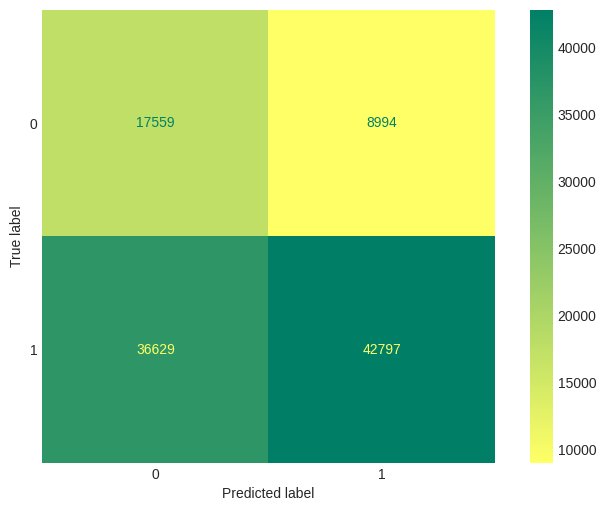

In [240]:
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=COLORMAP)
plt.grid(False)